# The Weisfeiler-Lehman Isomorphism Test

The Weisfeiler-Lehman Isomorphism Test, also called WL-Test, is a classical result from the graph theory. It is an heuristic to find out if two graphs are isomorphic. The problem of the graph isomorphism does not have a definitive solution in polinomial time yet, making some people say it may be NP-Complete. The WL-Test offers one alternative that allows us to estimate it.

However, since this is an heuristic, the test is not perfect. Therefore, it fail in some simple cases and because of that new versions of this test were proposed.

In this notebook we will explore a little about the theory of the test and implement it in its classical form and also some newer versions.

In [1]:
import copy
import pprint
import itertools
import hashlib
import networkx as nx

from collections import Counter

In [2]:
def base_WL(G_, k, verbose, n_set, initial_colors_func, find_neighbors_func):    
    if verbose:
        print('-----------------------------------')
        print('Starting the execution for the graph')
    G, n = n_set(G_)
    colors = initial_colors_func(n)

    old_colors = copy.deepcopy(colors)
    
    if verbose:
        print(f'Initial Color hashes: \n {colors} \n')

    for i in range(len(n)):
        for node in n:
            neigh_colors = "".join([colors[i][0] for i in find_neighbors_func(G, n, node)])
            
            colors[node].extend([neigh_colors])
            colors[node].sort()

        # Update with the hash
        if verbose:
            print(f'Colors before hashes at iteration {i}: {colors} \n')
        colors = {i: [hashlib.sha224("".join(colors[i]).encode('utf-8')).hexdigest()] for i in colors}
                
        if verbose:
            print(f'Colors hashes at iteration {i}: \n {colors} \n')
            print(f'Histogram: \n {sorted(Counter([item for sublist in colors.values() for item in sublist]).items())} \n')
        
        if list(Counter([item for sublist in colors.values() for item in sublist]).values()) == list(Counter([item for sublist in old_colors.values() for item in sublist]).values()) and i != 0:
            if verbose:
                print(f'Converged at iteration {i}!')
            break
        
        old_colors = copy.deepcopy(colors)

    canonical_form = sorted(Counter([item for sublist in colors.values() for item in sublist]).items())
    if verbose:
        print(f'Canonical Form Found: \n {canonical_form} \n')

    return canonical_form

In [3]:
def WL(G, k=2, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        return G, list(G.nodes())
    
    def set_initial_colors(n):
        return {i: [hashlib.sha224("1".encode('utf-8')).hexdigest()] for i in n}
    
    def find_neighbors(G, n, node):
        return G.neighbors(node)
    
    return base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)

In [29]:
def kWL(G, k, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        V = list(G.nodes())
        V_k = [comb for comb in itertools.combinations(V, k)]
        return G, V_k

    def set_initial_colors(n):
        return {i: [hashlib.sha224(str(i).encode('utf-8')).hexdigest()] for i in n}

    def find_neighbors(G, V_k, node):
        print([n for n in V_k if len(set(n) - set(V_k[V_k.index(node)])) == 1])
        return [n for n in V_k if len(set(n) - set(V_k[V_k.index(node)])) == 1]

    return base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)

In [50]:
def fkWL(G, k, verbose=False):
    def n_set(G):
        G = nx.convert_node_labels_to_integers(G)
        V = list(G.nodes())
        V_k = [comb for comb in itertools.product(V, repeat=k)]
        return G, V_k

    def set_initial_colors(n):
        return {i: [hashlib.sha224(str(i).encode('utf-8')).hexdigest()] for i in n}

    def find_neighbors(G, V_k, node):
        V = list(G.nodes())
        vals = []
        for i in range(k):
            w = []
            nodes_to_add = [u for u in V if u != V_k[V_k.index(node)][i]]
            for u in nodes_to_add:
                aux = list(V_k[V_k.index(node)])
                aux[i] = u
                w.append(tuple(aux))
            vals.extend(w)
        return vals

    return base_WL(G, k, verbose, n_set, set_initial_colors, find_neighbors)

In [51]:
def compare_graphs(G1, G2, method='WL', k=2, verbose=False):
    methods = {
        'WL': WL,
        'kWL': kWL,
        'fkWL': fkWL
    }

    # If two graphs have different numbers of nodes they cannot be isomorphic
    if len(G1.nodes()) != len(G2.nodes()):
        if verbose:
            print('Non-Isomorphic by different number of nodes!')
        return False
    
    c1 = methods[method](G1, k, verbose)
    c2 = methods[method](G2, k, verbose)

    return c1 == c2

## Testing the Implementation

In [145]:
G = nx.Graph()
G_edge_list = [(1, 2), (2, 3), (3, 1)]
G.add_edges_from(G_edge_list)

compare_graphs(G, G, k=2, verbose=True, method='kWL')

-----------------------------------
Starting the execution for the graph
Initial Color hashes: 
 {(0, 1): ['dd1ff31c7034df9b181dec11a0ae633bf9bee80662d76e1b5f655c2e'], (0, 2): ['af78931ab7820443f0986de9ef1f276363014d89b9dd587f16b5f3e5'], (1, 2): ['efc8967f524c37abb64097ebc4ca64c6c9a47e4ae3f6bd4bda7a52a3']} 

Colors before hashes at iteration 0: {(0, 1): ['af78931ab7820443f0986de9ef1f276363014d89b9dd587f16b5f3e5efc8967f524c37abb64097ebc4ca64c6c9a47e4ae3f6bd4bda7a52a3', 'dd1ff31c7034df9b181dec11a0ae633bf9bee80662d76e1b5f655c2e'], (0, 2): ['af78931ab7820443f0986de9ef1f276363014d89b9dd587f16b5f3e5', 'af78931ab7820443f0986de9ef1f276363014d89b9dd587f16b5f3e5efc8967f524c37abb64097ebc4ca64c6c9a47e4ae3f6bd4bda7a52a3efc8967f524c37abb64097ebc4ca64c6c9a47e4ae3f6bd4bda7a52a3'], (1, 2): ['af78931ab7820443f0986de9ef1f276363014d89b9dd587f16b5f3e5efc8967f524c37abb64097ebc4ca64c6c9a47e4ae3f6bd4bda7a52a3af78931ab7820443f0986de9ef1f276363014d89b9dd587f16b5f3e5', 'efc8967f524c37abb64097ebc4ca64c6c9a47e4ae3

True

## Evaluation

When evaluating, we must know that our implementation works besides the node naming. Also, we must test to some non-isomorphic graphs that cannot be distinguished by the WL test.

Example of Two Non-Isomorphic Graphs that fail the WL-Test <br>
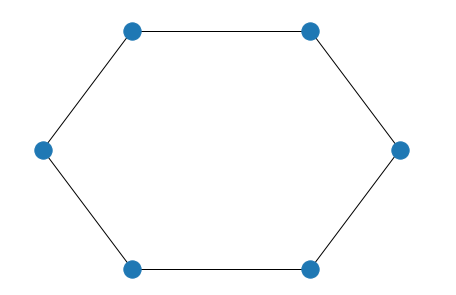
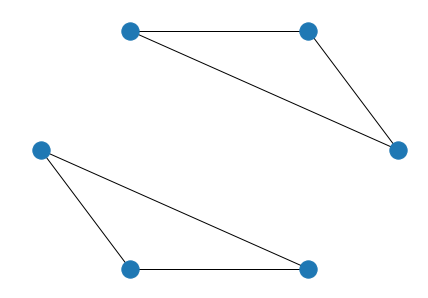 <br>

Another Example of Two Non-Isomorphic Graphs that fail the WL-Test <br>
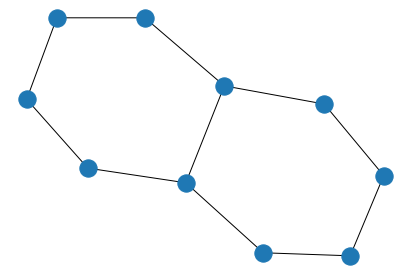
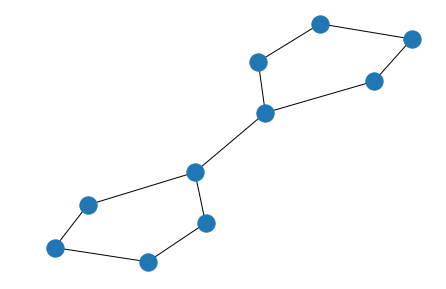

In [54]:
def evaluation(method, k):
    print(f'Method: {method}')
    
    # Generates two non-isomorphic graphs
    G = nx.Graph()
    G_edge_list = [(1, 2), (2, 3), (1, 3), (4, 5), (5, 6), (4, 6)]
    G.add_edges_from(G_edge_list)

    H = nx.Graph()
    H_edge_list = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)]
    H.add_edges_from(H_edge_list)
    
    G_ = nx.Graph()
    G_edge_list = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1), (3, 7), (7, 8), (8, 9), (9, 10), (10, 4)]
    G_.add_edges_from(G_edge_list)

    H_ = nx.Graph()
    H_edge_list = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (3, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 6)]
    H_.add_edges_from(H_edge_list)
    
    
    G1 = nx.davis_southern_women_graph()
    G2 = nx.karate_club_graph()
    G3 = nx.les_miserables_graph()
    G4 = nx.convert_node_labels_to_integers(G3)

    G5 = nx.convert_node_labels_to_integers(G3)
    G5.remove_edge(0, 1)

    print(f'Expected: False, got: {compare_graphs(G, H, method, k)}')
    print(f'Expected: False, got: {compare_graphs(G_, H_, method, k)}')
    print(f'Expected: True, got: {compare_graphs(G1, G1, method, k)}')
    print(f'Expected: True, got: {compare_graphs(G2, G2, method, k)}')
    print(f'Expected: True, got: {compare_graphs(G3, G3, method, k)}')
    print(f'Expected: True, got: {compare_graphs(G4, G4, method, k)}')
    print(f'Expected: True, got: {compare_graphs(G5, G5, method, k)}')
    
    print(f'Expected: True, got: {compare_graphs(G3, G4, method, k)}')
    print(f'Expected: False, got: {compare_graphs(G3, G5, method, k)}')
    print(f'Expected: False, got: {compare_graphs(G4, G5, method, k)}')

In [8]:
evaluation('WL', k=3)

Expected: False, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: False, got: False
Expected: False, got: False


In [9]:
evaluation('kWL', k=3)

Expected: False, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: True, got: True
Expected: False, got: False
Expected: False, got: False


In [53]:
evaluation('fkWL', k=3)

NameError: name 'evaluation' is not defined